# Florescent-Florescent Linear Image Registration
This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/affine_registration_3d.py

- Fixed image: DK52
- Moving image: DK43

In [1]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

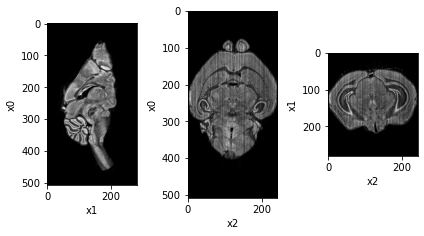

In [2]:
fixed_image = np.load('../data/ff/fixed_image.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

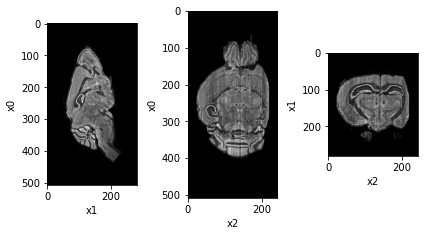

In [3]:
moving_image = np.load('../data/ff/moving_image.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [4]:
dtype = torch.float32
device = torch.device('cpu')
scales = [1, 1, 1]

fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, scales, [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, scales, [0, 0, 0])

## Prepare image pyramid

In [5]:
scales = [[4, 4, 4], [2, 2, 2]]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)

## Run registration

In [6]:
lr = 5e-3
niter = [64, 16, 4]

In [7]:
import time

start = time.time()

for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    print('level', level)
    registration = al.PairwiseRegistration(verbose=True)
    
    transformation = al.transformation.pairwise.AffineTransformation(mov_im)
    if level == 0:
        transformation.init_translation(fix_im)
    else:
        transformation.set_parameters(**parameters)
    registration.set_transformation(transformation)
    
    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])
    
    optimizer = torch.optim.Adam(transformation.parameters(), lr=lr)
    registration.set_optimizer(optimizer)
    
    registration.set_number_of_iterations(niter[level])
    registration.start()
    
    parameters = {
        't': (
            float(transformation._t_x),
            float(transformation._t_y),
            float(transformation._t_z)
        ),
        'phi': (
            float(transformation._phi_z),
            float(transformation._phi_x),
            float(transformation._phi_y),
        ),
        'scale': (
            float(transformation._scale_x),
            float(transformation._scale_y),
            float(transformation._scale_z)
        ),
        'shear': (
            float(transformation._shear_y_x),
            float(transformation._shear_x_y),
            float(transformation._shear_z_x),
            float(transformation._shear_z_y),
            float(transformation._shear_x_z),
            float(transformation._shear_y_z),
        ),
    }

end = time.time()
print((end - start) / 60, 'min')

level 0
0 mse: 0.008164874249534002 
1 mse: 0.007899456300795343 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(



2 mse: 0.007610319367983479 
3 mse: 0.0073777366968566585 
4 mse: 0.007124162457547509 
5 mse: 0.00689001351532854 
6 mse: 0.006713614581046826 
7 mse: 0.006514498091566996 
8 mse: 0.006316428904611854 
9 mse: 0.0061587964507544375 
10 mse: 0.006001665886702849 
11 mse: 0.0058504672198256835 
12 mse: 0.005681140223319931 
13 mse: 0.005514705637202187 
14 mse: 0.005376032420544186 
15 mse: 0.005241261644043897 
16 mse: 0.005110085562831955 
17 mse: 0.0049903028075132085 
18 mse: 0.004877421630771572 
19 mse: 0.004779296770206652 
20 mse: 0.004684526061164618 
21 mse: 0.004586948694527154 
22 mse: 0.0044741700031728565 
23 mse: 0.00435689797902852 
24 mse: 0.0042475773576694294 
25 mse: 0.004141057908882178 
26 mse: 0.004024877552611321 
27 mse: 0.003890245931756472 
28 mse: 0.0037584425757044397 
29 mse: 0.0036371652560793096 
30 mse: 0.0035319751534047595 
31 mse: 0.0034357479883898178 
32 mse: 0.003353162483083486 
33 mse: 0.003282514654199207 
34 mse: 0.0032100408667616893 
35 mse: 

## Examine results

In [8]:
transformation.print()

_phi_z 0.08687352089017986
_t_x 0.13648663939432096
_t_y 0.014096329585425647
_t_z 0.05188707107371318
_phi_x -0.2180236289877557
_phi_y -0.0016655175560161455
_scale_x 0.9590536895526456
_scale_y 0.9084191663099501
_scale_z 1.0359335904282678
_shear_y_x -0.07353510803202842
_shear_x_y 0.0029922869166723017
_shear_z_x 0.011823531971419743
_shear_z_y 0.20510434268865302
_shear_x_z 0.002054675468392748
_shear_y_z 0.08828011492940188


In [9]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image, displacement)
np.save('../data/ff/moving_image_after_linear_reg.npy', warped_image.image[0,0].numpy())

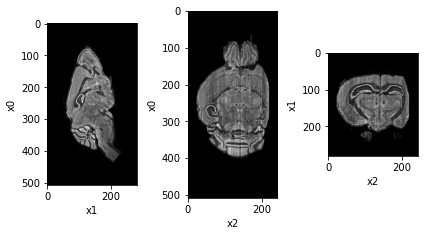

In [10]:
util.imshow_midslice(moving_image.image[0,0].numpy())

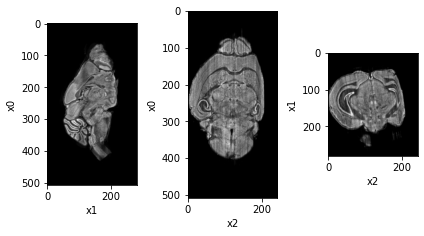

In [11]:
util.imshow_midslice(warped_image.image[0,0].numpy())

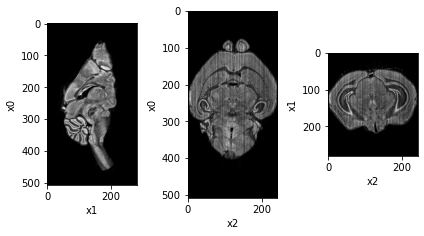

In [12]:
util.imshow_midslice(fixed_image.image[0,0].numpy())